# Aparna Ambarapu

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load 2022, 2023 BTC-USD, ETH-BTC, ETH-USD datasets

In [2]:
def read_dataset(year, pair1, pair2):
    path = './data/'+str(year)+'/trades_narrow_'+pair1+'-'+pair2+'_'+str(year)+'.delim.gz'
    df = pd.read_csv(path, sep='\t', compression='gzip', engine='python')
    df['Price'] = df['PriceMillionths']/1e6
    df['Size'] = df['SizeBillionths']/1e9
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc_nanoseconds'])
    # df['received_utc_nanoseconds'] = pd.to_datetime(df['received_utc_nanoseconds'])
    df['Side'] = np.sign(df['Side'])
    df.index.name = pair1+'-'+pair2
    return df.drop(columns=['timestamp_utc_nanoseconds','received_utc_nanoseconds', 'PriceMillionths', 'SizeBillionths'])


In [3]:
btc_usd_2022_df = read_dataset(2022, 'BTC', 'USD')
eth_btc_2022_df = read_dataset(2022, 'ETH', 'BTC')
eth_usd_2022_df = read_dataset(2022, 'ETH', 'USD')

btc_usd_2023_df = read_dataset(2023, 'BTC', 'USD')
eth_btc_2023_df = read_dataset(2023, 'ETH', 'BTC')
eth_usd_2023_df = read_dataset(2023, 'ETH', 'USD')

In [4]:
print(btc_usd_2022_df.shape)
print(eth_btc_2022_df.shape)
print(eth_usd_2022_df.shape)
print(btc_usd_2023_df.shape)
print(eth_btc_2023_df.shape)
print(eth_usd_2023_df.shape)

(2907376, 4)
(116525, 4)
(2711795, 4)
(560107, 4)
(1958, 4)
(377185, 4)


In [5]:
eth_btc_2023_df.head()

,Side,Price,Size,timestamp_utc
ETH-BTC,,,,
0,1,0.07095,0.259657,2023-01-24 00:49:06.020758
1,1,0.07095,0.000141,2023-01-24 00:49:06.050573
2,-1,0.07095,0.053583,2023-01-24 00:49:08.159815
3,-1,0.07094,0.000207,2023-01-24 00:49:12.601911
4,1,0.07095,0.000991,2023-01-24 00:52:26.201920


Here we going to assess the feasibility of accumulating large positions while attempting to maintain low trading costs in an electronic market. Before that we will take a look at the datasets.

# Exploratory data analysis

In [6]:
def find_time_gaps(df):
    df = df.set_index('timestamp_utc').copy()
    resampled = df.resample('1T')['Price'].count()
    return resampled[resampled == 0].index.tolist()

def metrics_df(df, pair, year):
    df = df.sort_values('timestamp_utc').copy()
    lst = find_time_gaps(df)

    start = df['timestamp_utc'].min()
    end = df['timestamp_utc'].max()
    start_floor = start.floor('1T')
    end_ceil = end.ceil('1T')
    total_intervals = len(pd.date_range(start_floor, end_ceil, freq='1T'))
    gap_pct = (len(lst) / total_intervals * 100) if total_intervals > 0 else 0.0

    return {
        'pair': pair,
        'year': year,
        'start': start,
        'end': end,
        'num_days': (end - start).days + 1,
        'total_records': len(df),
        'time_gaps': lst,
        'number_time_gaps': len(lst),
        'percentage_gaps': round(gap_pct, 2)
    }

In [7]:
PAIRS = ['BTC-USD', 'ETH-USD', 'ETH-BTC']
YEARS = [2022, 2023]

pair_year_dfs = {
    'BTC-USD': {
        2022: btc_usd_2022_df,
        2023: btc_usd_2023_df
    },
    'ETH-USD': {
        2022: eth_usd_2022_df,
        2023: eth_usd_2023_df
    },
    'ETH-BTC': {
        2022: eth_btc_2022_df,
        2023: eth_btc_2023_df
    }
}

In [8]:
results = []
for pair in PAIRS:
    for year in YEARS:
        df = pair_year_dfs[pair][year]
        metrics = metrics_df(df, pair, year)
        results.append(metrics)

summary_df = pd.DataFrame(results)
print("Dataset Summary:")
display(summary_df)

Dataset Summary:


,pair,year,start,end,num_days,total_records,time_gaps,number_time_gaps,percentage_gaps
0,BTC-USD,2022,2022-01-29 21:02:49.574850,2022-02-05 01:29:55.223562,7,2907376,[],0,0.00
1,BTC-USD,2023,2023-01-24 00:47:47.874527,2023-01-25 15:50:01.601767,2,560107,"[2023-01-24 03:00:00, 2023-01-24 03:01:00, 202...",694,29.59
2,ETH-USD,2022,2022-01-29 21:02:52.762420,2022-02-05 01:29:55.456813,7,2711795,[],0,0.00
3,ETH-USD,2023,2023-01-24 00:47:51.071902,2023-01-25 15:00:30.376266,2,377185,"[2023-01-24 01:01:00, 2023-01-24 01:02:00, 202...",1076,46.88
4,ETH-BTC,2022,2022-01-29 21:02:56.287757,2022-02-05 01:29:47.860828,7,116525,"[2022-01-30 07:50:00, 2022-01-30 08:16:00, 202...",26,0.29
5,ETH-BTC,2023,2023-01-24 00:49:06.020758,2023-01-25 15:08:05.145749,2,1958,"[2023-01-24 00:50:00, 2023-01-24 00:51:00, 202...",1774,77.10


We see that for all pairs, data in 2022 is available for 7 days and 2 days in 2023. High #trades happen for BTC-USD vs other pairs which is to be expected as Bitcoin is  There are significant timegaps in 2023, especially for ETH-BTC (~77%), while this percentage was calculated as len(1-minute gaps)/total 1-minute interval between start and end date, this gives us an idea of how good the data is. As suggested by Prof:
- Another reasonable thing to do would be to work with the data as-is, accepting the extreme tails in behavior as symptomatic of an actual (rather than idealized) system being the subject of analysis. So, We are going to ignore gaps for now.

In [9]:
def analyze_trade_volumes_all_pairs(pair_year_dfs, pairs, years, resample_interval='5T'):
    def resample_data(df):
        return df.set_index('timestamp_utc').resample(resample_interval).agg({
            'Size': 'sum',         # Total volume
            'Price': 'mean',       # Average price
            'Side': 'count'        # Number of trades
        }).rename(columns={'Size': 'volume', 'Price': 'avg_price', 'Side': 'trade_count'})

    # Resample all datasets
    volume_data_dict = {
        pair: {year: resample_data(pair_year_dfs[pair][year]) for year in years}
        for pair in pairs
    }

    # Plotting
    num_pairs = len(pairs)
    fig, axes = plt.subplots(num_pairs, len(years), figsize=(6 * len(years), 4 * num_pairs), sharey='row')

    if num_pairs == 1:
        axes = [axes]

    for i, pair in enumerate(pairs):
        for j, year in enumerate(years):
            ax = axes[i][j] if num_pairs > 1 else axes[j]
            volume_data = volume_data_dict[pair][year]
            ax.plot(volume_data.index, volume_data['volume'], label=f'{pair} Volume ({year})')
            ax.set_title(f'{resample_interval} Volume - {pair} ({year})')
            ax.set_xlabel('Timestamp')
            if j == 0:
                ax.set_ylabel('Volume')
            ax.legend()

    plt.tight_layout()
    plt.show()

    return volume_data_dict


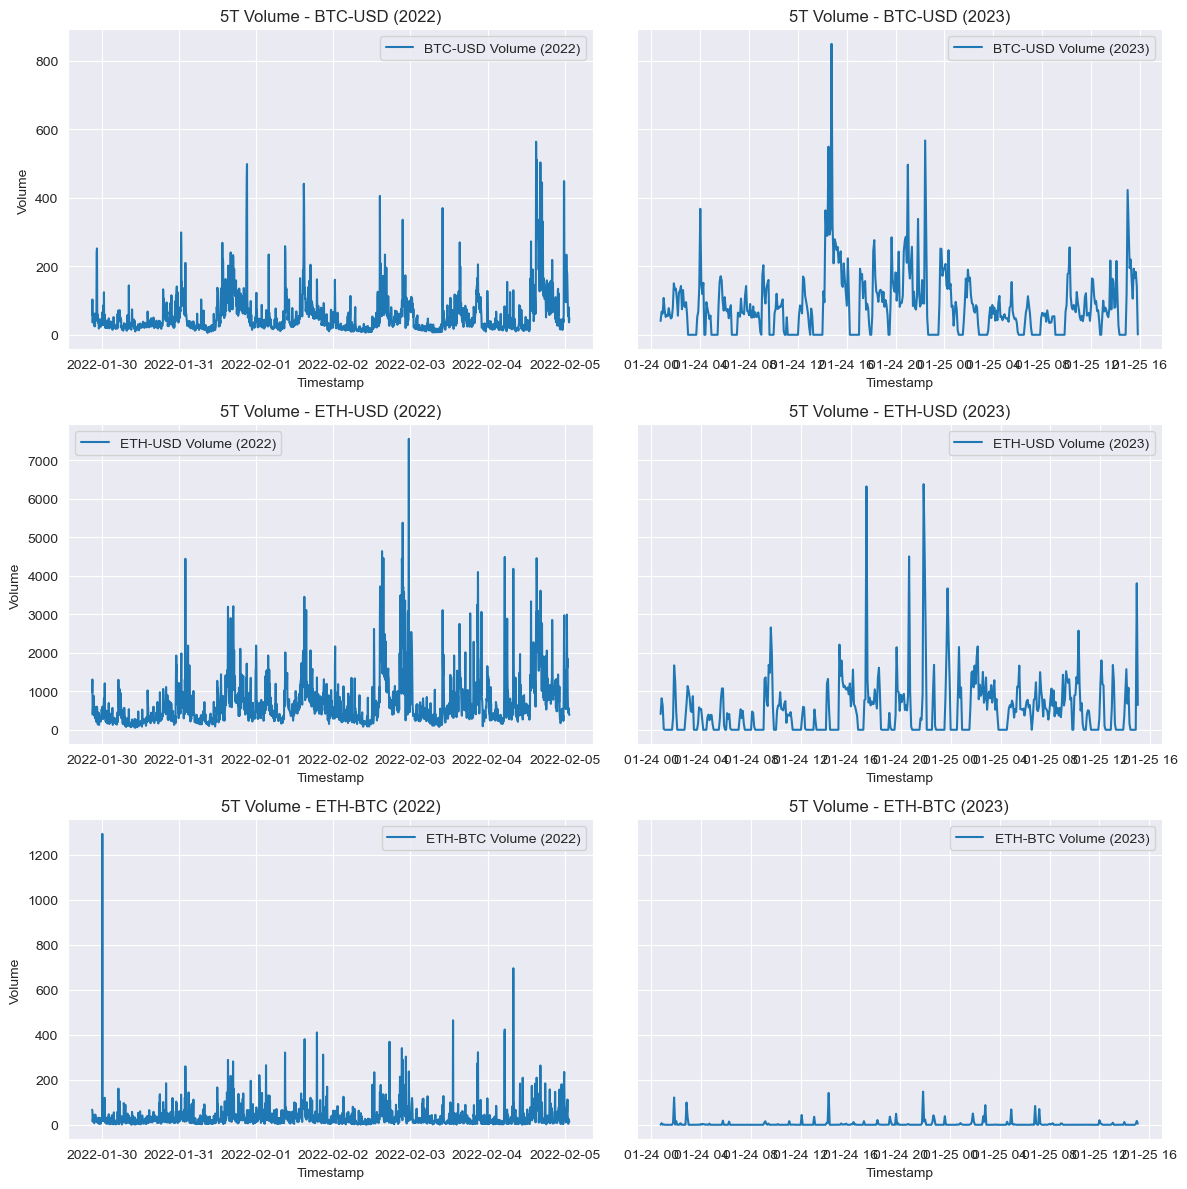

In [10]:
volume_data_dict = analyze_trade_volumes_all_pairs(pair_year_dfs, PAIRS, YEARS)

Re-iterating what we saw in summary table before, the data in 2023 has a lot of gaps (can be seen from the flat lines in the plot), and ETH-BTC has lot less trading activity compared to BTC-USD and ETH-USD.

### Key Insights from the Plots

BTC-USD
- 2022: Frequent volume spikes indicate active trading, with notable peaks suggesting market events or volatility.
- 2023: Spikes are more concentrated, possibly tied to specific market events like Bitcoin's price rally in January 2023.

ETH-USD
- 2022: Higher overall volumes compared to BTC-USD, with sharp spikes reflecting significant trading activity.
- 2023: Similar patterns but with fewer spikes due to shorter data coverage.

ETH-BTC
- 2022: A single large spike dominates, likely a result of a major trade or liquidity event. The rest of the period shows low, sporadic activity.
- 2023: Minimal trading volumes, indicating reduced interest or liquidity for token-to-token trades.

Real-World Context
1. BTC Rally (Jan 2023): Bitcoin's price surged by ~40% in January 2023, driving higher trading volumes.
2. ETH Activity: Ethereum's transition to proof-of-stake (The Merge) in late 2022 may have influenced ETH-related trading patterns in early 2023.
3. ETH-BTC Decline: Reduced interest in ETH-BTC pair trading could reflect a shift toward fiat-paired trades or declining arbitrage opportunities.

### Implications for Accumulation Strategies
High Volume Periods:
- BTC-USD and ETH-USD provide better opportunities for accumulation during volume spikes due to higher liquidity.
- ETH-BTC requires smaller target quantities and conservative participation rates to avoid market impact.

Data Coverage:
- Limited data for 2023 (2 days) may not fully capture yearly trends, requiring caution in drawing conclusions.

In [45]:
def calculate_vwap(df):
    """Calculate Volume Weighted Average Price (VWAP) for a DataFrame"""
    try:
        dollar_volume = (df['Price'] * df['Size']).sum()
        total_volume = df['Size'].sum()
        return dollar_volume / total_volume if total_volume != 0 else 0
    except KeyError:
        print("Missing required columns: 'Price' and/or 'Size'")
        return None

def calculate_pair_year_vwap(pair_year_dfs):
    """Calculate VWAP for all pairs and years in nested dictionary"""
    vwap_results = {}

    for pair, years in pair_year_dfs.items():
        vwap_results[pair] = {}
        for year, df in years.items():
            vwap_results[pair][year] = calculate_vwap(df)

    return vwap_results

In [46]:
vwap_results = calculate_pair_year_vwap(pair_year_dfs)
vwap_results

{'BTC-USD': {2022: 38236.19891122872, 2023: 22833.04847884836},
 'ETH-USD': {2022: 2717.0318965407732, 2023: 1583.8326817861039},
 'ETH-BTC': {2022: 0.07107147751023117, 2023: 0.06971473762602727}}

# Accumulation

## Helper functions

In [11]:
def calculate_Q_values(pair_year_dfs, quantiles=[65, 70], interval='5T', fraction=0.02):
    Q_dict = {}
    for pair, years in pair_year_dfs.items():
        Q_dict[pair] = {}
        for year, df in years.items():
            resampled = df.set_index('timestamp_utc').resample(interval)['Size'].sum()
            Q_vals = {f'{q}th': resampled.quantile(q/100) * fraction for q in quantiles}
            Q_dict[pair][year] = Q_vals
    return Q_dict

In [12]:
def generate_trade_df(df, Q, tau_s, Q_sign, g_quantile=0.05, k=0.05, P=0, fee_rate=0.005):
    # Filter trades based on start time and opposite side
    target_side = -Q_sign
    mask = (df['timestamp_utc'] >= tau_s) & (df['Side'] == target_side)
    filtered = df.loc[mask].copy()

    if filtered.empty:
        return None

    # Calculate minimum size threshold g
    g = filtered['Size'].abs().quantile(g_quantile)

    # Group trades by timestamp and calculate total quantities at each timestamp
    flurry_groups = filtered.groupby('timestamp_utc')
    q_levels = flurry_groups['Size'].sum()

    # Calculate size to accumulate at each timestamp
    s_values = ((q_levels - g) * k).clip(lower=0)

    # Identify sweeps (multiple price levels at the same timestamp)
    sweep_flags = flurry_groups['Price'].nunique() > 1
    sweep_timestamps = sweep_flags[sweep_flags].index

    # Apply pause time after sweeps
    pause_periods = pd.to_datetime(sweep_timestamps) + pd.to_timedelta(P, unit='s')
    pause_mask = filtered['timestamp_utc'].isin(pause_periods)

    # Filter valid trades after applying pause periods
    valid_trades_mask = ~pause_mask & ~filtered['timestamp_utc'].isin(sweep_timestamps)
    valid_trades = filtered.loc[valid_trades_mask]

    if valid_trades.empty:
        return None

    # Calculate cumulative participation
    valid_s_values = s_values.reindex(valid_trades['timestamp_utc']).fillna(0)
    cum_s = valid_s_values.cumsum()

    # Stop accumulating once we meet or exceed Q
    try:
        cutoff_idx = cum_s[cum_s >= abs(Q)].index.min()
        final_valid_trades = valid_trades[valid_trades['timestamp_utc'] <= cutoff_idx]
        total_size = cum_s.loc[cutoff_idx]
    except IndexError:
        final_valid_trades = valid_trades
        total_size = cum_s.iloc[-1] if not cum_s.empty else 0

    if final_valid_trades.empty or total_size == 0:
        return None

    # Assign participation sizes and calculate notional values
    participation_sizes = final_valid_trades.groupby('timestamp_utc')['Size'].transform(
        lambda x: (x.abs() / x.abs().sum()) * valid_s_values.get(x.name, 0)
    )

    trades_df = final_valid_trades.assign(
        size=participation_sizes * Q_sign,
        notional=lambda x: x['Price'] * x['size'].abs()
    )[['timestamp_utc', 'Price', 'size', 'notional']]


    arrival_price = df.loc[df['timestamp_utc'] >= tau_s].iloc[0]['Price']

    # Compute metrics
    fee_rate = fee_rate if 'usd' in df.index.name.lower() else 0.001
    duration_seconds = (
        trades_df['timestamp_utc'].max() - trades_df['timestamp_utc'].min()
    ).total_seconds()

    metrics = {
        'arrival_price': arrival_price,
        'vwap': trades_df['notional'].sum() / total_size,
        'total_notional': trades_df['notional'].sum(),
        'fees_paid': trades_df['notional'].sum() * fee_rate,
        'participation_rate': total_size / df.loc[(df['timestamp_utc'] <= trades_df['timestamp_utc'].max()) & (df['timestamp_utc'] >= trades_df['timestamp_utc'].min())]['Size'].abs().sum(),
        'duration_seconds': duration_seconds,
        'num_flurries': len(trades_df['timestamp_utc'].unique()),
        'filled_quantity': total_size * np.sign(Q),
        'target_quantity': Q,
        'remaining_quantity': Q - (total_size * np.sign(Q))
    }

    return trades_df, metrics

In [37]:
def analyze_simulation(metrics):
    analysis = {
        'slippage_bps': (metrics['vwap'] - metrics['arrival_price']) / metrics['arrival_price'] * 10000,
        'fee_bps': metrics['fees_paid'] / metrics['total_notional'] * 10000,
        'notional_per_minute': metrics['total_notional'] / (metrics['duration_seconds'] / 60)
    }
    return analysis

## calculating Q

In [14]:
Q_dict = calculate_Q_values(pair_year_dfs)
Q_dict

{'BTC-USD': {2022: {'65th': 1.05538934106, '70th': 1.19748401262},
  2023: {'65th': 1.81094512425, '70th': 2.0396249520399983}},
 'ETH-USD': {2022: {'65th': 13.922947902010005, '70th': 15.38895058914},
  2023: {'65th': 11.741779113510006, '70th': 13.691001553339989}},
 'ETH-BTC': {2022: {'65th': 0.6335377463600002, '70th': 0.7201435850399999},
  2023: {'65th': 0.0004878, '70th': 0.0022483476}}}

I tried to compute Q values using rolling 5 min cumsum() but it resulted in null values for ETH-BTC in 2023, so I shifted to calculating via partitioning data into 5 minute intervals and then getting xth percentile and taking Q as a fraction of it. Calculating different percentile values for ETH-BTC resulted in '0' values as there are gaps and less trading activity in that dataset, so I will be looking at just 65th and 70th percentile for the analysis.

I am currently using a fixed value for tau_s (arrival time) as 1hr after trade data start. I will do simulations on arrival times later. For all analysis:
- Q_sign = positive
- g_quantile =  0.05
- fee_rate = 0.005 for USD pair and 0.001 otherwise
- P = 2 sec after flurry trades

### k=0.03 and Q corresponding to 65th percentile

In [48]:
# Parameters for the function
Q_sign = 1
g_quantile = 0.05
k = 0.03
P = 2
fee_rate = 0.005

results = []
analysis_results = []

for pair, years in pair_year_dfs.items():
    for year, df in years.items():
        trades_df, metrics = generate_trade_df(df, Q=Q_dict[df.index.name][year]['65th'], tau_s=df['timestamp_utc'].iloc[0]+pd.Timedelta(hours=1), Q_sign=Q_sign, g_quantile=g_quantile, k=k, P=P, fee_rate=fee_rate)

        if metrics:
            metrics['pair'] = pair
            metrics['year'] = year
            metrics['vwap_trade_book'] = vwap_results[pair][year]
            results.append(metrics)

            analysis = analyze_simulation(metrics)
            analysis['pair'] = pair
            analysis['year'] = year
            analysis_results.append(analysis)

results_df = pd.DataFrame(results)
analysis_df = pd.DataFrame(analysis_results)

In [49]:
results_df

,arrival_price,vwap,total_notional,fees_paid,participation_rate,duration_seconds,num_flurries,filled_quantity,target_quantity,remaining_quantity,pair,year,vwap_trade_book
0,38388.18000,38241.639237,40402.789340,202.013947,0.003798,1337.457568,1193,1.056513,1.055389,-0.001124,BTC-USD,2022,38236.198911
1,23012.03000,23063.662402,41771.398334,208.856992,0.004694,834.882014,1046,1.811135,1.810945,-0.000190,BTC-USD,2023,22833.048479
2,2612.21000,2603.950572,36559.083059,182.795415,0.003794,2779.922701,1492,14.039853,13.922948,-0.116905,ETH-USD,2022,2717.031897
3,1632.67000,1634.965551,19988.119929,99.940600,0.007281,351.577984,425,12.225407,11.741779,-0.483628,ETH-USD,2023,1583.832682
4,0.06804,0.068139,0.043610,0.000044,0.009635,605.215868,62,0.640014,0.633538,-0.006477,ETH-BTC,2022,0.071071
5,0.07098,0.070980,0.001403,0.000001,0.029993,0.000000,1,0.019761,0.000488,-0.019273,ETH-BTC,2023,0.069715


In [52]:
results_df.columns

Index(['arrival_price', 'vwap', 'total_notional', 'fees_paid',
       'participation_rate', 'duration_seconds', 'num_flurries',
       'filled_quantity', 'target_quantity', 'remaining_quantity', 'pair',
       'year', 'vwap_trade_book'],
      dtype='object')

In [50]:
analysis_df

,slippage_bps,fee_bps,notional_per_minute,pair,year
0,-38.173407,50.0,1812.519080,BTC-USD,2022
1,22.437135,50.0,3001.961784,BTC-USD,2023
2,-31.618546,50.0,789.066898,ETH-USD,2022
3,14.060105,50.0,3411.155562,ETH-USD,2023
4,14.614643,10.0,0.004323,ETH-BTC,2022
5,0.000000,10.0,inf,ETH-BTC,2023


fee is proportional to notional as expected.
ETH-BTC for 2023 is not clean and hence we rely on its analysis/metrics values.

Liquidity: Notional trading volume per minute differs significantly by pair, indicating varying liquidity levels. Highest for BTC-USD in 2022 and for ETH-USD in 2023 (this is in line with what we saw volume charts)

Algorithm Performance :
   - VWAP Efficiency: The VWAP algorithm generally achieves prices close to or better than the arrival price, reflecting efficient execution.
   - Participation Rate: Higher participation rates lead to faster accumulation but may increase market impact.
   - Cost Breakdown: Fees and slippage are key contributors to total trading costs, with fees being more predictable.

Yearly and Pair-Specific Trends:
   - Performance metrics such as filled quantity, remaining quantity, and execution costs vary across trading pairs and between 2022 and 2023, influenced by market conditions like liquidity and volatility.


### k=0.03 and Q corresponding to 70th percentile

In [53]:
# Parameters for the function
Q_sign = 1
g_quantile = 0.05
k = 0.03
P = 2
fee_rate = 0.005

results = []
analysis_results = []

for pair, years in pair_year_dfs.items():
    for year, df in years.items():
        trades_df, metrics = generate_trade_df(df, Q=Q_dict[df.index.name][year]['70th'], tau_s=df['timestamp_utc'].iloc[0]+pd.Timedelta(hours=1), Q_sign=Q_sign, g_quantile=g_quantile, k=k, P=P, fee_rate=fee_rate)

        if metrics:
            metrics['pair'] = pair
            metrics['year'] = year
            metrics['vwap_trade_book'] = vwap_results[pair][year]
            results.append(metrics)

            analysis = analyze_simulation(metrics)
            analysis['pair'] = pair
            analysis['year'] = year
            analysis_results.append(analysis)

results_df = pd.DataFrame(results)
analysis_df = pd.DataFrame(analysis_results)

In [54]:
results_df

,arrival_price,vwap,total_notional,fees_paid,participation_rate,duration_seconds,num_flurries,filled_quantity,target_quantity,remaining_quantity,pair,year,vwap_trade_book
0,38388.18000,38227.048351,46082.036472,230.410182,0.001772,1787.950565,1447,1.205482,1.197484,-0.007998,BTC-USD,2022,38236.198911
1,23012.03000,23067.703205,47050.226878,235.251134,0.004715,972.605569,1194,2.039658,2.039625,-0.000033,BTC-USD,2023,22833.048479
2,2612.21000,2603.625547,40885.914832,204.429574,0.003741,3445.214962,1823,15.703454,15.388951,-0.314504,ETH-USD,2022,2717.031897
3,1632.67000,1635.284927,22792.329440,113.961647,0.007636,360.836697,469,13.937834,13.691002,-0.246832,ETH-USD,2023,1583.832682
4,0.06804,0.068136,0.049112,0.000049,0.009916,765.453638,77,0.720802,0.720144,-0.000659,ETH-BTC,2022,0.071071
5,0.07098,0.070980,0.001403,0.000001,0.029993,0.000000,1,0.019761,0.002248,-0.017512,ETH-BTC,2023,0.069715


In [55]:
analysis_df

,slippage_bps,fee_bps,notional_per_minute,pair,year
0,-41.974287,50.0,1546.419819,BTC-USD,2022
1,24.193087,50.0,2902.526680,BTC-USD,2023
2,-32.862798,50.0,712.046974,ETH-USD,2022
3,16.016263,50.0,3789.913215,ETH-USD,2023
4,14.091406,10.0,0.003850,ETH-BTC,2022
5,0.000000,10.0,inf,ETH-BTC,2023


similar performance as previous case. changing Q doesn't impact our results much. Higher duration because Q(70th) > Q(65th). Apart from BTC-USD in 2022, participation_rate has increased when using Q(70th). notional_per_minute is higher for Q(65th) in 2022 and Q(70th) in 2023, since 2023 has fewer days and gaps, we need to take caution in making conclusions.

In [ ]:
results_df['price_deviation_vwap'] = (results_df['vwap'] - results_df['arrival_price']) / results_df['arrival_price']
results_df['price_deviation_book'] = (results_df['vwap_trade_book'] - results_df['arrival_price']) / results_df['arrival_price']
results_df['cost_proportion'] = results_df['fees_paid'] / results_df['total_notional']
results_df['efficiency'] = results_df['total_notional'] / results_df['duration_seconds']

summary_stats = results_df.groupby(['pair', 'year']).agg({
    'arrival_price': 'mean',
    'vwap': 'mean',
    'vwap_trade_book': 'mean',
    'price_deviation_vwap': ['mean', 'std'],
    'price_deviation_book': ['mean', 'std'],
    'participation_rate': ['mean', 'std'],
    'cost_proportion': 'mean',
    'efficiency': 'mean'
}).reset_index()

plt.figure(figsize=(16, 12))

# Price comparison
plt.subplot(2, 2, 1)
sns.boxplot(x='pair', y='price_deviation_vwap', hue='year', data=results_df)
plt.title('Price Deviation from Arrival (VWAP)')
plt.ylabel('Relative Deviation')

plt.subplot(2, 2, 2)
sns.boxplot(x='pair', y='price_deviation_book', hue='year', data=results_df)
plt.title('Price Deviation from Arrival (Trade Book VWAP)')
plt.ylabel('Relative Deviation')

# Participation vs Deviation
plt.subplot(2, 2, 3)
sns.scatterplot(x='participation_rate', y='price_deviation_vwap',
                hue='pair', style='year', data=results_df)
plt.title('Participation Rate vs Price Deviation')
plt.xlabel('Achieved Participation Rate')
plt.ylabel('VWAP Deviation')

# Efficiency comparison
plt.subplot(2, 2, 4)
sns.barplot(x='pair', y='efficiency', hue='year', data=results_df)
plt.title('Trading Efficiency (Notional/Second)')
plt.ylabel('Efficiency')

plt.tight_layout()
plt.show()


In [63]:
comparison_results = []
for pair in PAIRS:
    for year in YEARS:
        subset = results_df[(results_df['pair'] == pair) & (results_df['year'] == year)]

        comparison_results.append({
            'pair': pair,
            'year': year,
            'mean_vwap_diff': (subset['vwap'] - subset['vwap_trade_book']).mean(),
            'cost_ratio': subset['cost_proportion'].mean(),
            'completion_rate': subset['filled_quantity'].mean() / subset['target_quantity'].mean()
        })

comparison_df = pd.DataFrame(comparison_results)

In [64]:
print("\n=== Key Performance Metrics ===")
(comparison_df[['pair', 'year', 'mean_vwap_diff', 'cost_ratio', 'completion_rate']])


=== Key Performance Metrics ===


,pair,year,mean_vwap_diff,cost_ratio,completion_rate
0,BTC-USD,2022,-9.150560,0.005,1.006679
1,BTC-USD,2023,234.654726,0.005,1.000016
2,ETH-USD,2022,-113.406350,0.005,1.020437
3,ETH-USD,2023,51.452246,0.005,1.018029
4,ETH-BTC,2022,-0.002936,0.001,1.000915
5,ETH-BTC,2023,0.001265,0.001,8.788943


# Next Steps:
- I wanted to calculate participation rates for different random values of arrival time and look at it distribution and understand how much k led to that participation rate, to understand the relationship between k and final participation rates.
- Influence of Q